Analysis of data from fault-scarp model runs.

Start by setting up arrays to hold the data.

In [8]:
import numpy as np

N = 125
run_number = np.zeros(N)
hill_length = np.zeros(N)
dist_rate = np.zeros(N)
uplint = np.zeros(N)
max_ht = np.zeros(N)
mean_slope = np.zeros(N)
mean_ht = np.zeros(N)

Set up info on domain size and parameters.

In [9]:
domain_lengths = np.array([58, 103, 183, 325, 579])
disturbance_rates = 10.0 ** np.array([-3, -2.5, -2, -1.5, -1])
uplift_intervals = 10.0 ** np.array([2, 2.5, 3, 3.5, 4])
for i in range(N):
    hill_length[i] = domain_lengths[i // 25]
    dist_rate[i] = disturbance_rates[i % 5]
    uplint[i] = uplift_intervals[(i // 5) % 5]
print(hill_length)
print(dist_rate)
print(uplint)

[  58.   58.   58.   58.   58.   58.   58.   58.   58.   58.   58.   58.
   58.   58.   58.   58.   58.   58.   58.   58.   58.   58.   58.   58.
   58.  103.  103.  103.  103.  103.  103.  103.  103.  103.  103.  103.
  103.  103.  103.  103.  103.  103.  103.  103.  103.  103.  103.  103.
  103.  103.  183.  183.  183.  183.  183.  183.  183.  183.  183.  183.
  183.  183.  183.  183.  183.  183.  183.  183.  183.  183.  183.  183.
  183.  183.  183.  325.  325.  325.  325.  325.  325.  325.  325.  325.
  325.  325.  325.  325.  325.  325.  325.  325.  325.  325.  325.  325.
  325.  325.  325.  325.  579.  579.  579.  579.  579.  579.  579.  579.
  579.  579.  579.  579.  579.  579.  579.  579.  579.  579.  579.  579.
  579.  579.  579.  579.  579.]
[ 0.001       0.00316228  0.01        0.03162278  0.1         0.001
  0.00316228  0.01        0.03162278  0.1         0.001       0.00316228
  0.01        0.03162278  0.1         0.001       0.00316228  0.01
  0.03162278  0.1         0.00

Read data from file.

In [10]:
import csv

i = -1
with open('../ModelRuns/TransLim5x5x5paramStudy/param5x5results.csv', 'rb') as csvfile:
    myreader = csv.reader(csvfile)
    for row in myreader:
        if i > -1:
            run_number[i] = int(row[0])
            max_ht[i] = float(row[1])
            mean_ht[i] = float(row[2])
            mean_slope[i] = float(row[3])
        i += 1
csvfile.close()

Let's revisit the question of how to plot, now that I seem to have solved the "not run long enough" problem. If you take the primary variables, the scaling is something like

$h = f( d, \tau, \lambda )$

There is just one dimension here: time. So our normalization becomes simply:

$h = f( d\tau, \lambda )$

This suggests plotting $h$ versus $d\tau$ segregated by $\lambda$.

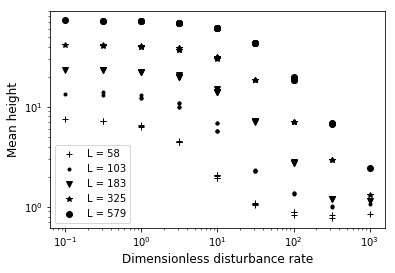

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

dtau = dist_rate * uplint  # Here's our dimensionless disturbance rate

syms = ['k+', 'k.', 'kv', 'k*', 'ko']
for i in range(5):
    idx = (i * 25) + np.arange(25)
    plt.loglog(dtau[idx], mean_ht[idx], syms[i])
plt.xlabel('Dimensionless disturbance rate', {'fontsize' : 12})
plt.ylabel('Mean height', {'fontsize' : 12})
plt.legend(['L = 58', 'L = 103', 'L = 183', 'L = 325', 'L = 579'])
plt.savefig('mean_ht_vs_dist_rate.pdf')

This is actually a fairly straightforward result. For any given hillslope width, there are three domains: (1) threshold, in which height is independent of disturbance or uplift rate; (2) linear, in which height is inversely proportional to $d\tau$, and (3) finite-size, where mean height is only one or two cells, and which is basically meaningless and can be ignored.

Next, let's look at the effective diffusivity. One method is to start with mean hillslope height, $H_m$. Diffusion theory predicts that mean height should be given by:

$H = \frac{U}{3D}L^2$

Then simply invert this to solve for $D$:

$D = \frac{U}{3H}L^2$

In the particle model, $H$ in real length units is equal to height in cells, $h$, times scale of a cell, $\delta$. Similarly, $L = \lambda \delta / 2$, and $U = \delta / I_u$, where $I_u$ is uplift interval in cells/time (the factor of 2 in $\lambda$ comes from the fact that hillslope length is half the domain length). Substituting,

$D = \frac{4}{3I_u h} \lambda^2 \delta^2$

This of course requires defining cell size. We could also do it in terms of a disturbance rate, $d_{eff}$, equal to $D/\delta^2$,

$d_{eff} = \frac{4}{3I_u h} \lambda^2$

Ok, here's a neat thing: we can define a dimensionless effective diffusivity as follows:

$D' = \frac{D}{d \delta^2} = \frac{4}{3 d I_u h} \lambda^2$

This measures the actual diffusivity relative to the nominal value reflected by the disturbance rate. Here we'll plot it against slope gradient in both linear and log-log.


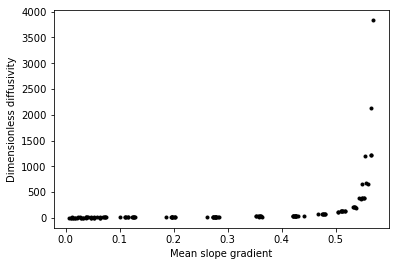

In [12]:
hill_halflen = hill_length / 2.0
D_prime = (hill_halflen * hill_halflen) / (3 * uplint * mean_ht * dist_rate)

plt.plot(mean_slope, D_prime, 'k.')
plt.xlabel('Mean slope gradient')
plt.ylabel('Dimensionless diffusivity')

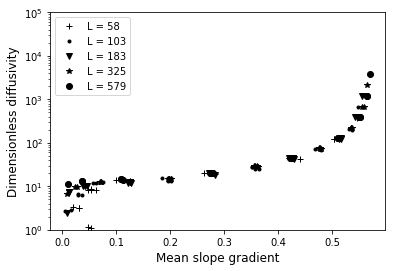

In [13]:
syms = ['k+', 'k.', 'kv', 'k*', 'ko']
for i in range(0, 5):
    idx = (i * 25) + np.arange(25)
    plt.semilogy(mean_slope[idx], D_prime[idx], syms[i])
plt.xlabel('Mean slope gradient', {'fontsize' : 12})
plt.ylabel('Dimensionless diffusivity', {'fontsize' : 12})
plt.ylim([1.0e0, 1.0e5])
plt.legend(['L = 58', 'L = 103', 'L = 183', 'L = 325', 'L = 579'])

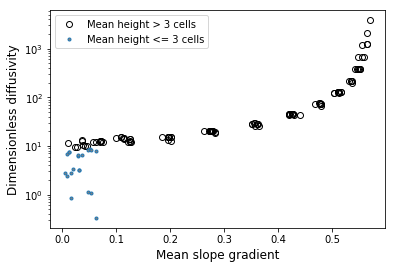

In [21]:
idx1 = np.where(max_ht > 3)[0]
idx2 = np.where(max_ht <= 3)[0]
plt.semilogy(mean_slope[idx1], D_prime[idx1], 'ko', mfc='none')
plt.semilogy(mean_slope[idx2], D_prime[idx2], '.', mfc='0.5')
plt.xlabel('Mean slope gradient', {'fontsize' : 12})
plt.ylabel('Dimensionless diffusivity', {'fontsize' : 12})
plt.legend(['Mean height > 3 cells', 'Mean height <= 3 cells'])
plt.savefig('dimless_diff_vs_grad.pdf')

Just for fun, let's try to isolate the portion of $D_e$ that doesn't contain Furbish et al.'s $\cos^2\theta$ factor. In other words, we'll plot against $\cos^2 \theta S$. Remember that $S=\tan \theta$, so $\theta = \tan^{-1} S$ and $\cos \theta = \cos\tan^{-1}S$.

In [18]:
theta = np.arctan(mean_slope)
cos_theta = np.cos(theta)
cos2_theta = cos_theta * cos_theta
cos2_theta_S = cos2_theta * mean_slope

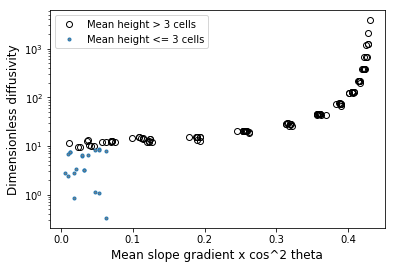

In [20]:
idx1 = np.where(max_ht > 3)[0]
idx2 = np.where(max_ht <= 3)[0]
plt.semilogy(cos2_theta_S[idx1], D_prime[idx1], 'ko', mfc='none')
plt.semilogy(cos2_theta_S[idx2], D_prime[idx2], '.', mfc='0.5')
plt.xlabel('Mean slope gradient x cos^2 theta', {'fontsize' : 12})
plt.ylabel('Dimensionless diffusivity', {'fontsize' : 12})
plt.legend(['Mean height > 3 cells', 'Mean height <= 3 cells'])
plt.savefig('dimless_diff_vs_grad_cos2theta.pdf')

Now let's try $D / (1 - (S/S_c)^2)$ and see if that collapses things...

In [24]:
Sc = np.tan(np.pi * 30.0 / 180.0)
de_with_denom = D_prime * (1.0 - (mean_slope / Sc) ** 2)

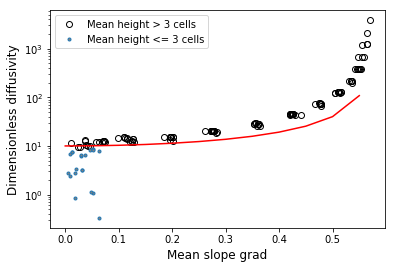

In [30]:
plt.semilogy(mean_slope[idx1], D_prime[idx1], 'ko', mfc='none')
plt.semilogy(mean_slope[idx2], D_prime[idx2], '.', mfc='0.5')
plt.xlabel('Mean slope grad', {'fontsize' : 12})
plt.ylabel('Dimensionless diffusivity', {'fontsize' : 12})
plt.legend(['Mean height > 3 cells', 'Mean height <= 3 cells'])

# Now add analytical
slope = np.arange(0, 0.6, 0.05)
D_pred = 10.0 / (1.0 - (slope/Sc)**2)
plt.plot(slope, D_pred, 'r')

====================================================

OLDER STUFF BELOW HERE

Start with a plot of $D$ versus slope for given fixed values of everything but $I_u$.

In [20]:
halflen = hill_length / 2.0
D = (halflen * halflen) / (2.0 * uplint * max_ht)
print np.amin(max_ht)

1.5


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

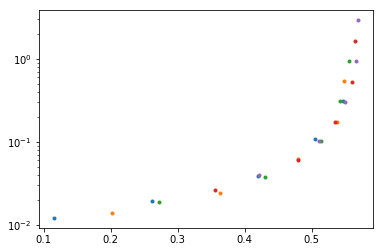

In [22]:
idx = np.arange(0, 25, 5)
plt.semilogy(mean_slope[idx], D[idx], '.')

idx = np.arange(25, 50, 5)
plt.plot(mean_slope[idx], D[idx], '.')

idx = np.arange(50, 75, 5)
plt.plot(mean_slope[idx], D[idx], '.')

idx = np.arange(75, 100, 5)
plt.plot(mean_slope[idx], D[idx], '.')

idx = np.arange(100, 125, 5)
plt.plot(mean_slope[idx], D[idx], '.')



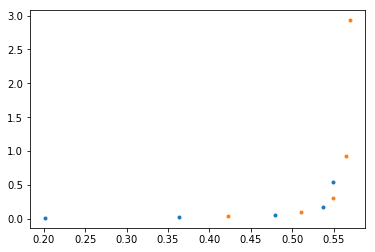

In [23]:
idx = np.arange(25, 50, 5)
plt.plot(mean_slope[idx], D[idx], '.')

idx = np.arange(100, 125, 5)
plt.plot(mean_slope[idx], D[idx], '.')

Is there something we could do with integrated elevation? To reduce noise... 

$\int_0^L z(x) dx = A = \int_0^L \frac{U}{2D}(L^2 - x^2) dx$

$A= \frac{U}{2D}L^3 - \frac{U}{6D}L^3$

$A= \frac{U}{3D}L^3$

$A/L = H_{mean} = \frac{U}{3D}L^2$

Rearranging,

$D = \frac{U}{3H_{mean}}L^2$

$D/\delta^2 = \frac{1}{3 I_u h_{mean}} \lambda^2$

This might be more stable, since it measures area (a cumulative metric).

First, a little nondimensionalization. We have an outcome, mean height, $h_m$, that is a function of three inputs: disturbance rate, $d$, system length $\lambda$, and uplift interval, $I_u$. If we treat cells as a kind of dimension, our dimensions are: C, C/T, C, T/C. This implies two dimensionless parameters:

$h_m / \lambda = f( d I_u )$

So let's calculate these quantities:

In [24]:
hmp = mean_ht / hill_length
di = dist_rate * uplint

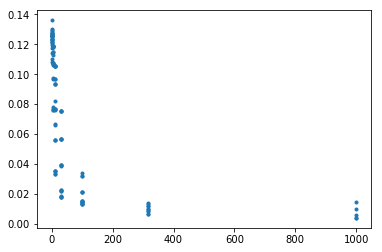

In [25]:
plt.plot(di, hmp, '.')

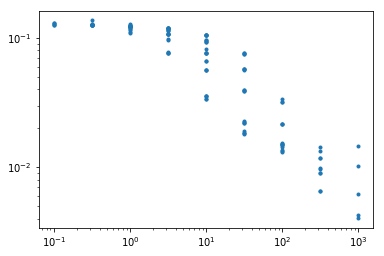

In [26]:
plt.loglog(di, hmp, '.')

I guess that's kind of a collapse? Need to split apart by different parameters. But first, let's try the idea of an effective diffusion coefficient:

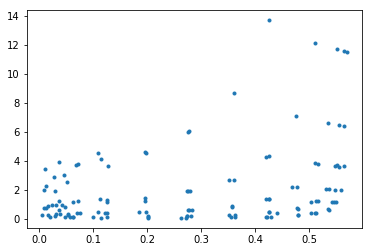

In [27]:
dd = (1.0 / (uplint * mean_ht)) * halflen * halflen
plt.plot(mean_slope, dd, '.')

Ok, kind of a mess. Let's try holding everything but uplift interval constant.

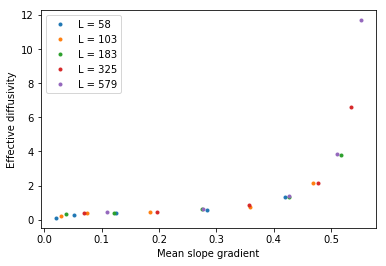

In [30]:
var_uplint = np.arange(0, 25, 5) + 2
for i in range(5):
    idx = (i * 25) + var_uplint
    plt.plot(mean_slope[idx], dd[idx], '.')
plt.xlabel('Mean slope gradient')
plt.ylabel('Effective diffusivity')
plt.legend(['L = 58', 'L = 103', 'L = 183', 'L = 325', 'L = 579'])

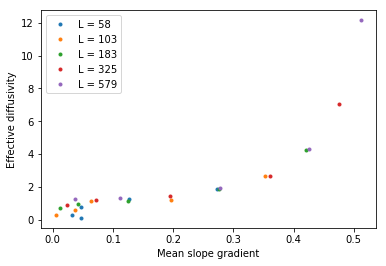

In [31]:
var_uplint = np.arange(0, 25, 5) + 3
for i in range(5):
    idx = (i * 25) + var_uplint
    plt.plot(mean_slope[idx], dd[idx], '.')
plt.xlabel('Mean slope gradient')
plt.ylabel('Effective diffusivity')
plt.legend(['L = 58', 'L = 103', 'L = 183', 'L = 325', 'L = 579'])

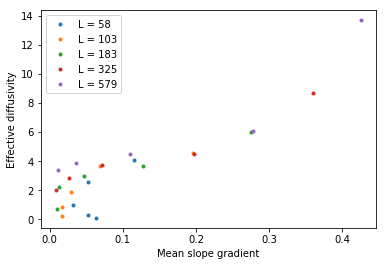

In [32]:
var_uplint = np.arange(0, 25, 5) + 4
for i in range(5):
    idx = (i * 25) + var_uplint
    plt.plot(mean_slope[idx], dd[idx], '.')
plt.xlabel('Mean slope gradient')
plt.ylabel('Effective diffusivity')
plt.legend(['L = 58', 'L = 103', 'L = 183', 'L = 325', 'L = 579'])

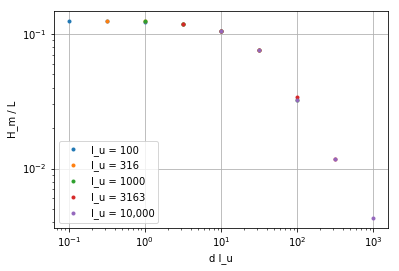

In [33]:
for i in range(5):
    idx = np.arange(5) + 100 + 5 * i
    plt.loglog(di[idx], hmp[idx], '.')
plt.xlabel('d I_u')
plt.ylabel('H_m / L')
plt.grid('on')
plt.legend(['I_u = 100', 'I_u = 316', 'I_u = 1000', 'I_u = 3163', 'I_u = 10,000'])

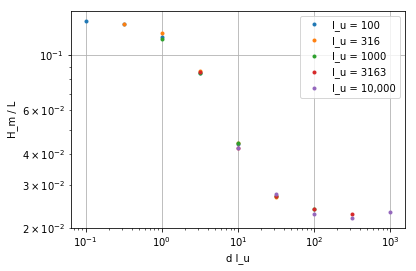

In [34]:
hmp2 = (mean_ht + 0.5) / hill_length
for i in range(5):
    idx = np.arange(5) + 0 + 5 * i
    plt.loglog(di[idx], hmp2[idx], '.')
plt.xlabel('d I_u')
plt.ylabel('H_m / L')
plt.grid('on')
plt.legend(['I_u = 100', 'I_u = 316', 'I_u = 1000', 'I_u = 3163', 'I_u = 10,000'])

They don't seem to segregate much by $I_u$. I suspect they segregate by $L$. So let's plot ALL the data, colored by $L$:

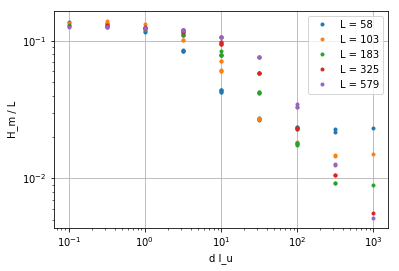

In [35]:
for i in range(5):
    idx = i * 25 + np.arange(25)
    plt.loglog(di[idx], hmp2[idx], '.')
plt.xlabel('d I_u')
plt.ylabel('H_m / L')
plt.grid('on')
plt.legend(['L = 58', 'L = 103', 'L = 183', 'L = 325', 'L = 579'])

The above plot makes sense actually. Consider the end members:

At low $d I_u$, you have angle-of-repose:

$H_m = \tan (30^\circ) L/4$ (I think)

or

$H_m / L \approx 0.15$

At high $d I_u$, we have the diffusive case:

$H_m = \frac{U}{3D} L^2$, or

$H_m / L = \frac{U}{3D} L$

But wait a minute, that's backwards from what the plot shows. Could this be a finite-size effect? Let's suppose that finite-size effects mean that there's a minimum $H_m$ equal to $N$ times the size of one particle. Then,

$H_m / L = N / L$

which has the right direction. What would $N$ actually be? From reading the graph above, estimate that (using $L$ as half-length, so half of the above numbers in legend):

For $L=29$, $N/L \approx 0.02$

For $L=51.5$, $N/L \approx 0.015$

For $L=91.5$, $N/L \approx 0.009$

For $L=162.5$, $N/L \approx 0.0055$

For $L=289.5$, $N/L \approx 0.004$

In [36]:
nl = np.array([0.02, 0.015, 0.009, 0.0055, 0.004])
l = np.array([29, 51.5, 91.5, 162.5, 289.5])
n = nl * l
n

array([ 0.58   ,  0.7725 ,  0.8235 ,  0.89375,  1.158  ])

In [37]:
1.0 / l

array([ 0.03448276,  0.01941748,  0.01092896,  0.00615385,  0.00345423])

Ok, so these are all hovering around 1 cell! So, that could well explain the scatter at the right side.

This is starting to make more sense. The narrow window around $d I_u \approx 10$ represents the diffusive regime. To the left, the angle-of-repose regime. To the right, the finite-size-effect regime. For good reasons, the diffusive regime is biggest with the biggest $L$ (more particles, so finite-size effect doesn't show up until larger $d I_u$). Within the diffusive regime, points separate according to scale, reflecting the $H_m / L \propto L$ effect. So, if we took points with varying $L$ but identical $d I_u$, ...

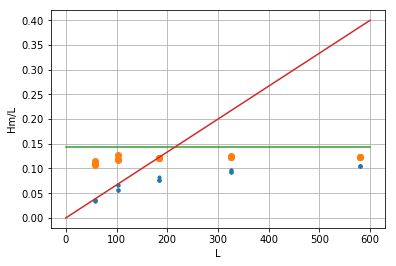

In [38]:
idx = np.where(np.logical_and(di>9.0, di<11.0))[0]
hmd = mean_ht[idx]
ld = hill_length[idx]
plt.plot(ld, hmd/ld, '.')
idx2 = np.where(np.logical_and(di>0.9, di<1.1))[0]
plt.plot(hill_length[idx2], mean_ht[idx2]/hill_length[idx2], 'o')
plt.grid('on')
plt.xlabel('L')
plt.ylabel('Hm/L')
plt.plot([0, 600.0], [0.5774/4.0, 0.5774/4.0])
plt.plot([0.0, 600.0], [0.0, 0.02 * 0.1/3.0 * 600.0])

In the above plot, diffusive behavior is indicated by a slope of 1:1, whereas angle-of-repose is indicated by a flat trend. One thing this says is that, for a given $d I_u$, a longer slope is more likely to be influenced by the angle of repose. That makes sense I think...? 

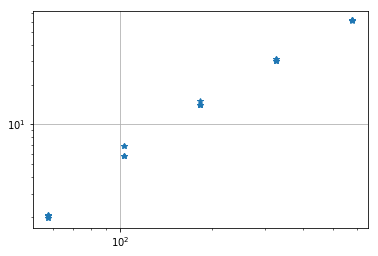

In [39]:
plt.loglog(ld, hmd, '*')
plt.grid('on')

Now, what if it's better to consider disturbance rate, $d$, to be in square cells / time? That is, when dimensionalized, to be $L^2/T$ rather than $L/T$? Let's see what happens when we do it this way:

In [40]:
d2 = dist_rate * uplint / hill_length

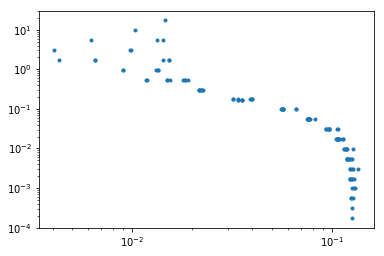

In [41]:
plt.loglog(hmp, d2, '.')

Not so great ...



Let's try another idea, based again on dimensional analysis. Start with dimensional quantities $U$ (uplift rate), $L$ (length), $H$ (mean height), and $\delta$ (cell size). Nondimensionalize in a somewhat surprising way:

$\frac{UL^2}{Hd\delta^2} = f( d\delta / U, L/\delta )$

This is actually a dimensionless diffusivity: diffusivity relative to disturbance intensity.

Now translate back: $H=h\delta$, $U=\delta / I_u$, and $L=\lambda \delta$:

$\frac{\lambda^2}{hdI_u} = f( d I_u, \lambda )$

So what happens if we plot thus?

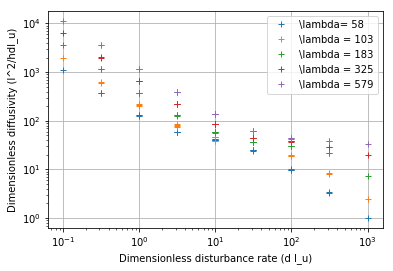

In [42]:
diff_nd = halflen * halflen / (uplint * mean_ht * dist_rate)
diu = dist_rate * uplint
for i in range(5):
    idx = (i * 25) + np.arange(25)
    plt.loglog(diu[idx], diff_nd[idx], '+')
plt.grid('on')
plt.xlabel('Dimensionless disturbance rate (d I_u)')
plt.ylabel('Dimensionless diffusivity (l^2/hdI_u)')
plt.legend(['\lambda= 58', '\lambda = 103', '\lambda = 183', '\lambda = 325', '\lambda = 579'])

Now THAT'S a collapse. Good. Interpretation: as we go left to right, we go from faster uplift or lower disturbance to slower uplift or faster disturbance. That means the relief goes from high to low. At high relief, we get angle-of-repose behavior, for which the effective diffusivity increases with relief---hence, diffusivity decreases with increasing $dI_u$. Then we get to a realm that is presumably the diffusive regime, where the curve flattens out. This represents a constant diffusivity. Finally, we get to the far right side, where you hit finite-size effects: there will be a hill at least one particle high on average no matter how high $d I_u$, so diffusivity appears to drop again.

There's a one-to-one relation between $D'$ and $\lambda$, at least in the steep regime. This reflects simple scaling. In the steep regime, $H = S_c L / 4$. By definition $D' = (U / 3H\delta^2 d) L^2$, or $H = (U / 3D'\delta^2 d) L^2$. Substituting,

$(U / 3D'\delta^2 d) L^2 = S_c L / 4$

$D' = 4 U L / 3 \delta^2 d S_c$

in other words, we expect $D' \propto L$ in this regime. (If we translate back, this writes as

$D' = 4 \lambda / 3 I_u d S_c$

Voila!

Ok, but why does the scaling between $D'$ and $\lambda$ continue in the diffusive regime? My guess is as follows. To relate disturbance rate, $d$, to diffusivity, $D$, consider that disturbance acts over depth $\delta$ and length $L$. Therefore, one might scale diffusivity as follows:

$D \propto dL\delta \propto d \lambda$

By that argument, $D$ should be proportional to $\lambda$. Another way to say this is that in order to preserve constant $D$, $d$ should be treated as a scale-dependent parameter: $d \propto D/\lambda$.


A further thought: can we define diffusivity more carefully? One approach would be

(frequency of disturbance events per unit time per unit length, $F$) [1/LT]

x

(cross-sectional area disturbed, $A$)

x

(characteristic displacement length,$\Lambda$)

For the first, take the expected number of events across the whole in unit time and divide by the length of the slope:

$F = \lambda d / L = ...$

hmm, this isn't going where I thought...
